In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.stats as stats
from analysis import *

# Load and prepare data

In [2]:
# Helper function to compute recall speed
def recall_speed(X_es, spikes, start_time):
    recall_speeds = []
    clu_pos = [linalg.norm(clu_end - clu_start) * clu / (clu_num-1) for clu in range(clu_num)]
    for i in tqdm(range(len(X_es))):
        clu_neurs = get_cluster_neurons(X_es[i])
        spikes_dic = spikes[i]
        firing_times = []
        for clu in range(clu_num):
            spikes_clu = get_spikes(clu_neurs[clu], spikes_dic, start_time)
            firing_times.append(rates_ftimes(spikes_clu, start_time, len(clu_neurs[clu]))[1])
        firing_times = np.array(firing_times).T
        spCCs = np.array(sp_corr(firing_times))
        recall_speeds_i = []
        #breakpoint()
        for ftimes in firing_times[spCCs > 0.9]:
            recall_speeds_i.append(stats.linregress(ftimes, clu_pos)[0])
        if len(recall_speeds_i)>0:
            recall_speeds.append(np.mean(recall_speeds_i))
    return recall_speeds

In [3]:
# Load date and compute recall speeds
af_time = growth_time + test_time + 2*relax_time + learn_time
vlist = [4, 8, 12, 16, 20]
recall_speeds = []
for i_v, v in tqdm(enumerate(vlist)):
    X_es = []
    spikes = []
    for i in range(40 + i_v*20, 40 + i_v*20 + seeds_num):
        if i!=6:
            data = load_data("./data/seqlearn_cues_v{}_seed{}.pickle".format(v, i))
        X_es.append(data["X_e"])
        spikes.append(data["spikes"])
    recall_speeds.append(recall_speed(X_es, spikes, af_time))

# Figure

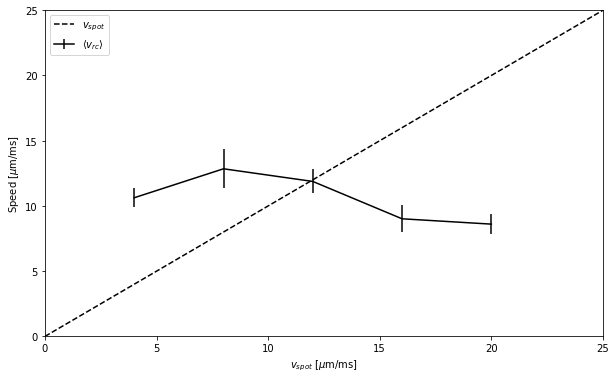

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot([0] + vlist + [max(vlist)+5], [0] + vlist + [max(vlist)+5],'k--', 
      label = r'$v_{spot}$')
recall_speeds_mean = 10**3 * np.array([np.mean(vs) for vs in recall_speeds])
recall_speeds_sem = 10**3 * np.array([stats.sem(vs) for vs in recall_speeds])
ax.errorbar(vlist, recall_speeds_mean, yerr=recall_speeds_sem, fmt='k', capsize=0, 
          label = r'$\langle v_{rc} \rangle$')

ax.set_xlim(0, max(vlist)+5)
ax.set_ylim(0, 25)
ax.set_ylabel(r'Speed [$\mu$m/ms]')
ax.set_xlabel(r'$v_{spot}$ [$\mu$m/ms]')
ax.legend()

plt.show()